# Naive RNN Forecast on Financial Data

### Description
This file is intended to demonstrate a simple and believably inaccurate version of RNN forecast on financial data. The data passed into the RNN model will only involve simple feature engineering.

### Imports & Settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
pd.options.display.max_rows = 50

### Read Data

In [3]:
# Data downloaded from investing.com and transformed by 
df = pd.read_csv('HSI Futures.csv', index_col='Date')

In [4]:
df

,Close,Open,High,Low
Date,,,,
2009-11-19,22537,22752,22853,22537
2009-11-20,22408,22543,22599,22357
2009-11-23,22772,22514,22805,22486
2009-11-24,22476,22785,22819,22263
2009-11-25,22606,22462,22680,22356
...,...,...,...,...
2020-08-17,25293,25052,25574,25014
2020-08-18,25341,25330,25440,25213
2020-08-19,25135,25349,25395,25041


## Method 1: Only Daily Return
Use previous returns to predict the direction.

In [5]:
df1 = df.copy()

In [6]:
df1['return'] = (df1['Close'] / df1.shift(1)['Close']) - 1

In [7]:
df1['target'] = np.sign(df1['return']).apply(lambda x: 0 if x == -1.0 else x)

In [8]:
df1.dropna(inplace=True)
df1.drop(['Close', 'Open', 'High', 'Low'], axis=1, inplace=True)

### Define features and target

In [9]:
df1x = df1['return']
df1y = df1['target']

In [10]:
T1 = 20
D1 = 1
N1 = len(df1) - T1
split1 = N1 // 3 * 2

X1 = []
Y1 = []

for t in range(N1):
    X1.append(df1x.iloc[t:t+T1])
    Y1.append(df1y.iloc[t+T1])
    
X1 = np.array(X1).reshape(N1, T1, D1)
Y1 = np.array(Y1)

### SimpleRNN

In [11]:
model1_simple = Sequential([
    Input((T1, D1)),
    SimpleRNN(5),
    Dense(1, activation='sigmoid')
])

model1_simple.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
r1_simple = model1_simple.fit(X1[:split1], Y1[:split1], epochs=100, batch_size=25, validation_data=(X1[split1:], Y1[split1:]))

Train on 1752 samples, validate on 876 samples
Epoch 1/100
1752/1752 [==============================] - 4s 2ms/sample - loss: 0.6933 - accuracy: 0.5285 - val_loss: 0.6902 - val_accuracy: 0.5354
Epoch 2/100
1752/1752 [==============================] - 1s 658us/sample - loss: 0.6934 - accuracy: 0.5217 - val_loss: 0.6904 - val_accuracy: 0.5331
Epoch 3/100
1752/1752 [==============================] - 1s 636us/sample - loss: 0.6927 - accuracy: 0.5080 - val_loss: 0.6911 - val_accuracy: 0.5331
Epoch 4/100
1752/1752 [==============================] - 1s 622us/sample - loss: 0.6950 - accuracy: 0.5160 - val_loss: 0.6917 - val_accuracy: 0.5388
Epoch 5/100
1752/1752 [==============================] - 1s 629us/sample - loss: 0.6932 - accuracy: 0.5166 - val_loss: 0.6905 - val_accuracy: 0.5331
Epoch 6/100
1752/1752 [==============================] - 1s 627us/sample - loss: 0.6928 - accuracy: 0.5245 - val_loss: 0.6905 - val_accuracy: 0.5331
Epoch 7/100
1752/1752 [==============================] - 1s 6

1752/1752 [==============================] - 1s 629us/sample - loss: 0.6923 - accuracy: 0.5240 - val_loss: 0.6910 - val_accuracy: 0.5331
Epoch 56/100
1752/1752 [==============================] - 1s 599us/sample - loss: 0.6923 - accuracy: 0.5240 - val_loss: 0.6911 - val_accuracy: 0.5331
Epoch 57/100
1752/1752 [==============================] - 1s 635us/sample - loss: 0.6923 - accuracy: 0.5240 - val_loss: 0.6909 - val_accuracy: 0.5331
Epoch 58/100
1752/1752 [==============================] - 1s 631us/sample - loss: 0.6923 - accuracy: 0.5240 - val_loss: 0.6911 - val_accuracy: 0.5331
Epoch 59/100
1752/1752 [==============================] - 1s 640us/sample - loss: 0.6922 - accuracy: 0.5240 - val_loss: 0.6910 - val_accuracy: 0.5331
Epoch 60/100
1752/1752 [==============================] - 1s 618us/sample - loss: 0.6923 - accuracy: 0.5240 - val_loss: 0.6910 - val_accuracy: 0.5331
Epoch 61/100
1752/1752 [==============================] - 1s 611us/sample - loss: 0.6923 - accuracy: 0.5240 - val

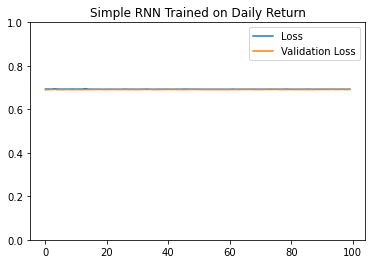

In [34]:
plt.plot(r1_simple.history['loss'], label='Loss')
plt.plot(r1_simple.history['val_loss'], label='Validation Loss')
plt.ylim(0, 1)

plt.title('Simple RNN Trained on Daily Return')
plt.legend()
plt.show()

In [14]:
pred1_simple = model1_simple.predict(X1[split1:])
pred1_simple

array([[0.5238049 ],
       [0.5239044 ],
       [0.5240732 ],
       [0.52391475],
       [0.5238477 ],
       [0.5238704 ],
       [0.52394414],
       [0.52393085],
       [0.5238507 ],
       [0.5240007 ],
       [0.5239385 ],
       [0.52376777],
       [0.5239074 ],
       [0.52389485],
       [0.5239906 ],
       [0.5239005 ],
       [0.52378374],
       [0.5238847 ],
       [0.5239204 ],
       [0.5239531 ],
       [0.5238465 ],
       [0.5238588 ],
       [0.5239743 ],
       [0.5239764 ],
       [0.52387565],
       [0.523722  ],
       [0.5239511 ],
       [0.52412814],
       [0.52383596],
       [0.52371854],
       [0.5241599 ],
       [0.52397007],
       [0.52375054],
       [0.52383214],
       [0.52385414],
       [0.5239868 ],
       [0.523955  ],
       [0.52380884],
       [0.52393603],
       [0.52398247],
       [0.52383125],
       [0.52377206],
       [0.5240055 ],
       [0.52405894],
       [0.5237727 ],
       [0.52378947],
       [0.523997  ],
       [0.523

### LSTM
If SimpleRNN does not work, would a more sophisticated LSTM succeed?

In [15]:
model1_lstm = Sequential([
    Input((T1, D1)),
    LSTM(5),
    Dense(1, activation='sigmoid')
])

model1_lstm.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
r1_lstm = model1_lstm.fit(X1[:split1], Y1[:split1], epochs=100, batch_size=25, validation_data=(X1[split1:], Y1[split1:]))

Train on 1752 samples, validate on 876 samples
Epoch 1/100
1752/1752 [==============================] - 8s 4ms/sample - loss: 0.6928 - accuracy: 0.5074 - val_loss: 0.6909 - val_accuracy: 0.5331
Epoch 2/100
1752/1752 [==============================] - 1s 763us/sample - loss: 0.6933 - accuracy: 0.5240 - val_loss: 0.6909 - val_accuracy: 0.5331
Epoch 3/100
1752/1752 [==============================] - 2s 913us/sample - loss: 0.6926 - accuracy: 0.5240 - val_loss: 0.6911 - val_accuracy: 0.5331
Epoch 4/100
1752/1752 [==============================] - 2s 898us/sample - loss: 0.6926 - accuracy: 0.5240 - val_loss: 0.6909 - val_accuracy: 0.5331
Epoch 5/100
1752/1752 [==============================] - 2s 885us/sample - loss: 0.6926 - accuracy: 0.5240 - val_loss: 0.6910 - val_accuracy: 0.5331
Epoch 6/100
1752/1752 [==============================] - 2s 869us/sample - loss: 0.6924 - accuracy: 0.5240 - val_loss: 0.6912 - val_accuracy: 0.5331
Epoch 7/100
1752/1752 [==============================] - 2s 8

1752/1752 [==============================] - 2s 949us/sample - loss: 0.6923 - accuracy: 0.5240 - val_loss: 0.6910 - val_accuracy: 0.5331
Epoch 56/100
1752/1752 [==============================] - 2s 969us/sample - loss: 0.6926 - accuracy: 0.5240 - val_loss: 0.6910 - val_accuracy: 0.5331
Epoch 57/100
1752/1752 [==============================] - 2s 906us/sample - loss: 0.6921 - accuracy: 0.5240 - val_loss: 0.6910 - val_accuracy: 0.5331
Epoch 58/100
1752/1752 [==============================] - 2s 927us/sample - loss: 0.6921 - accuracy: 0.5240 - val_loss: 0.6912 - val_accuracy: 0.5331
Epoch 59/100
1752/1752 [==============================] - 2s 969us/sample - loss: 0.6922 - accuracy: 0.5240 - val_loss: 0.6911 - val_accuracy: 0.5331
Epoch 60/100
1752/1752 [==============================] - 2s 944us/sample - loss: 0.6922 - accuracy: 0.5240 - val_loss: 0.6910 - val_accuracy: 0.5331
Epoch 61/100
1752/1752 [==============================] - 2s 929us/sample - loss: 0.6924 - accuracy: 0.5240 - val

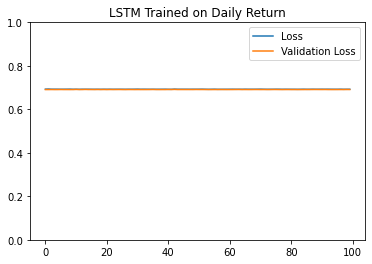

In [35]:
plt.plot(r1_lstm.history['loss'], label='Loss')
plt.plot(r1_lstm.history['val_loss'], label='Validation Loss')
plt.ylim(0, 1)

plt.title('LSTM Trained on Daily Return')
plt.legend()
plt.show()

In [18]:
pred1 = model1_lstm.predict(X1[split1:])
pred1

array([[0.5236434 ],
       [0.5236434 ],
       [0.523643  ],
       [0.5236431 ],
       [0.52364296],
       [0.5236431 ],
       [0.523643  ],
       [0.523643  ],
       [0.5236431 ],
       [0.5236428 ],
       [0.5236429 ],
       [0.52364314],
       [0.523643  ],
       [0.5236434 ],
       [0.523643  ],
       [0.5236431 ],
       [0.5236433 ],
       [0.5236433 ],
       [0.52364343],
       [0.52364326],
       [0.5236434 ],
       [0.5236434 ],
       [0.52364326],
       [0.5236431 ],
       [0.523643  ],
       [0.52364343],
       [0.52364326],
       [0.52364296],
       [0.5236431 ],
       [0.52364314],
       [0.52364254],
       [0.52364296],
       [0.5236428 ],
       [0.52364296],
       [0.5236434 ],
       [0.52364326],
       [0.5236432 ],
       [0.5236433 ],
       [0.52364314],
       [0.52364314],
       [0.52364326],
       [0.5236434 ],
       [0.5236432 ],
       [0.523643  ],
       [0.52364326],
       [0.52364326],
       [0.5236432 ],
       [0.523

In [19]:
df1.iloc[:split1]['target'].mean()

0.5222602739726028

## Method 2: OHLC Data
OHLC stands for Open, High, Low and Close. In machine learning, regression prediction is a harder job compared to classification because of the difficulty to predict continuous value and to analyse the results, e.g. accuracy. Therefore, the target will be transformed into a daily return direction, namely positive (1) or negative (0).

In addition, in finance, the value of the index does not carry much prediction power per se. Thus the high, low and open data will be transformed into proportions to close.

One extra column on daily returns will be added.

In [20]:
df2 = df.copy()

In [21]:
df2['return'] = (df2['Close'] / df2.shift(1)['Close']) - 1

In [22]:
df2['target'] = np.sign(df2['return']).apply(lambda x: 0 if x == -1.0 else x)

In [23]:
for col in ['Open', 'High', 'Low']:
    df2[col] = df2[col] / df2['Close'] - 1

In [24]:
df2.dropna(inplace=True)
df2.drop('Close', axis=1, inplace=True)

In [25]:
df2

,Open,High,Low,return,target
Date,,,,,
2009-11-20,0.006025,0.008524,-0.002276,-0.005724,0.0
2009-11-23,-0.011330,0.001449,-0.012559,0.016244,1.0
2009-11-24,0.013748,0.015261,-0.009477,-0.012998,0.0
2009-11-25,-0.006370,0.003273,-0.011059,0.005784,1.0
2009-11-26,0.021425,0.021425,-0.003563,-0.019287,0.0
...,...,...,...,...,...
2020-08-17,-0.009528,0.011110,-0.011031,0.008734,1.0
2020-08-18,-0.000434,0.003907,-0.005051,0.001898,1.0
2020-08-19,0.008514,0.010344,-0.003740,-0.008129,0.0


### Define features and target

In [26]:
df2x = df2.drop('target', axis=1)
df2y = df2['target']

In [27]:
T2 = 20
D2 = 4
N2 = len(df2) - T2
split2 = N2 // 3 * 2

X2 = []
Y2 = []

for t in range(N2):
    X2.append(df2x.iloc[t:t+T2])
    Y2.append(df2y.iloc[t+T2])
    
X2 = np.array(X2).reshape(N2, T2, D2)
Y2 = np.array(Y2)

In [28]:
model2_lstm = Sequential([
    Input((T2, D2)),
    LSTM(5),
    Dense(1, activation='sigmoid')
])

model2_lstm.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
r2_lstm = model2_lstm.fit(X2[:split2], Y2[:split2], epochs=100, batch_size=25, validation_data=(X2[split2:], Y2[split2:]))

Train on 1752 samples, validate on 876 samples
Epoch 1/100
1752/1752 [==============================] - 8s 5ms/sample - loss: 0.6931 - accuracy: 0.5228 - val_loss: 0.6914 - val_accuracy: 0.5331
Epoch 2/100
1752/1752 [==============================] - 2s 1ms/sample - loss: 0.6921 - accuracy: 0.5228 - val_loss: 0.6911 - val_accuracy: 0.5331
Epoch 3/100
1752/1752 [==============================] - 2s 899us/sample - loss: 0.6931 - accuracy: 0.5240 - val_loss: 0.6913 - val_accuracy: 0.5331
Epoch 4/100
1752/1752 [==============================] - 2s 924us/sample - loss: 0.6928 - accuracy: 0.5240 - val_loss: 0.6909 - val_accuracy: 0.5331
Epoch 5/100
1752/1752 [==============================] - 2s 940us/sample - loss: 0.6924 - accuracy: 0.5240 - val_loss: 0.6909 - val_accuracy: 0.5331
Epoch 6/100
1752/1752 [==============================] - 2s 953us/sample - loss: 0.6925 - accuracy: 0.5240 - val_loss: 0.6910 - val_accuracy: 0.5331
Epoch 7/100
1752/1752 [==============================] - 2s 996

1752/1752 [==============================] - 2s 870us/sample - loss: 0.6922 - accuracy: 0.5240 - val_loss: 0.6910 - val_accuracy: 0.5331
Epoch 56/100
1752/1752 [==============================] - 2s 1ms/sample - loss: 0.6926 - accuracy: 0.5240 - val_loss: 0.6914 - val_accuracy: 0.5331
Epoch 57/100
1752/1752 [==============================] - 2s 902us/sample - loss: 0.6924 - accuracy: 0.5240 - val_loss: 0.6912 - val_accuracy: 0.5331
Epoch 58/100
1752/1752 [==============================] - 2s 941us/sample - loss: 0.6922 - accuracy: 0.5240 - val_loss: 0.6912 - val_accuracy: 0.5331
Epoch 59/100
1752/1752 [==============================] - 2s 950us/sample - loss: 0.6925 - accuracy: 0.5240 - val_loss: 0.6912 - val_accuracy: 0.5331
Epoch 60/100
1752/1752 [==============================] - 1s 855us/sample - loss: 0.6922 - accuracy: 0.5240 - val_loss: 0.6912 - val_accuracy: 0.5331
Epoch 61/100
1752/1752 [==============================] - 1s 845us/sample - loss: 0.6922 - accuracy: 0.5240 - val_l

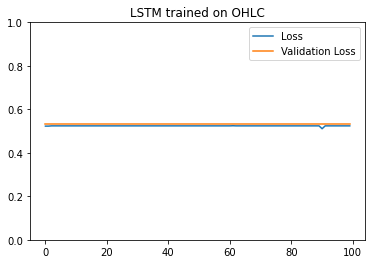

In [36]:
plt.plot(r2_lstm.history['accuracy'], label='Loss')
plt.plot(r2_lstm.history['val_accuracy'], label='Validation Loss')
plt.ylim(0, 1)

plt.title('LSTM trained on OHLC')
plt.legend()
plt.show()

In [38]:
pred2 = model2_lstm.predict(X2[split2:])
pred2

array([[0.53303456],
       [0.53303075],
       [0.5330434 ],
       [0.5330456 ],
       [0.5330528 ],
       [0.5330478 ],
       [0.5330426 ],
       [0.5330458 ],
       [0.5330479 ],
       [0.53305644],
       [0.533057  ],
       [0.5330488 ],
       [0.5330498 ],
       [0.53303325],
       [0.53304505],
       [0.5330464 ],
       [0.53303653],
       [0.5330359 ],
       [0.5330247 ],
       [0.53303283],
       [0.5330151 ],
       [0.53302234],
       [0.5330301 ],
       [0.53304046],
       [0.5330498 ],
       [0.5330323 ],
       [0.5330403 ],
       [0.53304994],
       [0.5330448 ],
       [0.533046  ],
       [0.5330607 ],
       [0.5330524 ],
       [0.53305596],
       [0.5330533 ],
       [0.53302866],
       [0.5330325 ],
       [0.5330391 ],
       [0.53303444],
       [0.5330418 ],
       [0.53304106],
       [0.53303605],
       [0.5330282 ],
       [0.5330385 ],
       [0.5330498 ],
       [0.5330416 ],
       [0.53304577],
       [0.5330435 ],
       [0.533